In [1]:
pip install yfinance fredapi investpy statsmodels pandas numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [128]:
import yfinance as yf
import pandas as pd
import numpy as np
from fredapi import Fred
import investpy
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import VECM, select_coint_rank, coint_johansen, select_order, VECMResults
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose

            Nominal Interest Rate  Inflation  German 10Y Bund Yield
2008-12-01                   3.25      91.47               3.047895
2009-01-01                   2.50      90.73               3.070952
2009-02-01                   2.00      91.10               3.127500
2009-03-01                   2.00      91.44               3.019545
2009-04-01                   1.50      91.76               3.133000


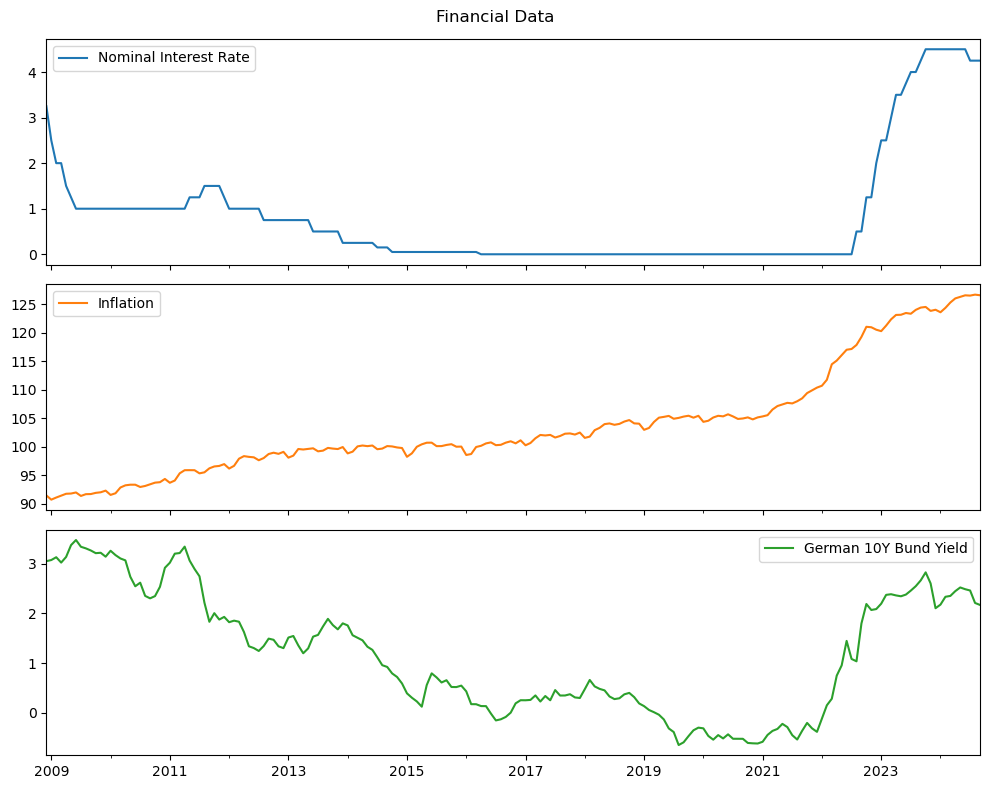

Data has been saved to 'financial_data.csv'.


In [151]:
# Set up FRED API key (replace with your actual FRED API key)
fred = Fred(api_key='975880224a9528750613f99ef2c4658a')

# Define the start and end dates for the data
start_date = '2008-12-01'
end_date = '2023-12-31'

# Download nominal interest rate data (ECB Main Refinancing Rate) from FRED
nominal_interest_rate = fred.get_series('ECBMRRFR', start=start_date, end=end_date)

# Download inflation data (Eurozone CPI) from FRED
inflation = fred.get_series('CP0000EZ19M086NEST', start=start_date, end=end_date)

# Download German 10-Year Bund Yield from FRED
german_bund_yield = fred.get_series('IRLTLT01DEM156N', start=start_date, end=end_date)

# Combine all series into a DataFrame
df_combined = pd.concat([nominal_interest_rate, inflation, german_bund_yield], axis=1)
df_combined.columns = ['Nominal Interest Rate', 'Inflation', 'German 10Y Bund Yield']

# Drop missing data and make sure index is datetime
df_combined = df_combined.dropna()
df_combined.index = pd.to_datetime(df_combined.index)

# Filter the data to only include rows from 2008-01-01 onwards
df_combined = df_combined[df_combined.index >= '2008-12-01']


# Display the first few rows of the DataFrame
print(df_combined.head())

# Plot the data for visualization
df_combined.plot(subplots=True, figsize=(10, 8), title="Financial Data")
plt.tight_layout()
plt.show()

# Save the  data to CSV (optional)
df_combined.to_csv("financial_data.csv", index=True)

print("Data has been saved to 'financial_data.csv'.")

In [117]:
print(df_combined.tail())

            Nominal Interest Rate  German 10Y Bund Yield  inflation_rate
2024-05-01                   4.50               2.519545        0.002140
2024-06-01                   4.50               2.484500        0.002136
2024-07-01                   4.25               2.458261       -0.000395
2024-08-01                   4.25               2.207727        0.001343
2024-09-01                   4.25               2.168000       -0.000869


In [152]:
# Take the log of the inflation index (HICP)
df_combined['log_Inflation'] = np.log(df_combined['Inflation'])

# Display the first few rows to verify
print(df_combined[['Inflation', 'log_Inflation']].head())

            Inflation  log_Inflation
2008-12-01      91.47       4.516011
2009-01-01      90.73       4.507888
2009-02-01      91.10       4.511958
2009-03-01      91.44       4.515683
2009-04-01      91.76       4.519176


In [97]:
# Calculate the log difference to approximate the inflation rate
df_combined['inflation_rate'] = df_combined['log_Inflation'].diff()

# Drop missing values created by differencing
df_combined = df_combined.dropna()

# Display the first few rows of the inflation rate
print(df_combined[['log_Inflation', 'inflation_rate']].head())

            log_Inflation  inflation_rate
2009-01-01       4.507888       -0.008123
2009-02-01       4.511958        0.004070
2009-03-01       4.515683        0.003725
2009-04-01       4.519176        0.003493
2009-05-01       4.519612        0.000436


In [98]:
# Assuming 'df_combined' is your DataFrame and it has a DateTimeIndex
df_combined.index = pd.to_datetime(df_combined.index)
# Filter the data to only include rows from 2008-01-01 onwards
df_combined = df_combined[df_combined.index >= '2009-01-01']
print(df_combined.head())
print(df_combined.index.min())  # Confirm that the earliest date is now in 2009

            Nominal Interest Rate  Inflation  German 10Y Bund Yield  \
2009-01-01                   2.50      90.73               3.070952   
2009-02-01                   2.00      91.10               3.127500   
2009-03-01                   2.00      91.44               3.019545   
2009-04-01                   1.50      91.76               3.133000   
2009-05-01                   1.25      91.80               3.371000   

            log_Inflation  inflation_rate  
2009-01-01       4.507888       -0.008123  
2009-02-01       4.511958        0.004070  
2009-03-01       4.515683        0.003725  
2009-04-01       4.519176        0.003493  
2009-05-01       4.519612        0.000436  
2009-01-01 00:00:00


In [99]:
# Drop 'log_Inflation' from DataFrame
df_combined = df_combined.drop(["log_Inflation", "Inflation"], axis=1)
print(df_combined.head())

            Nominal Interest Rate  German 10Y Bund Yield  inflation_rate
2009-01-01                   2.50               3.070952       -0.008123
2009-02-01                   2.00               3.127500        0.004070
2009-03-01                   2.00               3.019545        0.003725
2009-04-01                   1.50               3.133000        0.003493
2009-05-01                   1.25               3.371000        0.000436


In [100]:
# Check if there are any NaN values
print(df_combined.isna().sum())

Nominal Interest Rate    0
German 10Y Bund Yield    0
inflation_rate           0
dtype: int64


In [101]:
# Set frequency to month start
df_combined = df_combined.asfreq('MS')

# Check for missing values
print(df_combined.isna().sum())

Nominal Interest Rate    0
German 10Y Bund Yield    0
inflation_rate           0
dtype: int64


In [102]:
print(df_combined.index.freq)

<MonthBegin>


**ADF Test - with 3 specifications**

In [103]:


# Function to perform ADF test with different specifications and formatted output
def adf_test_with_specifications(series, name, signif=0.05):
    print(f'\n{"="*40}')
    print(f'ADF Test for {name}')
    print(f'{"="*40}')

    # 1. No constant, no trend (None)
    result_none = adfuller(series.dropna(), regression='n', autolag='AIC')
    adf_stat_none = result_none[0]
    p_value_none = result_none[1]
    critical_values_none = result_none[4]

    print(f'\nSpecification: No constant, no trend')
    print(f'ADF Statistic: {adf_stat_none:.4f}')
    print(f'p-value: {p_value_none:.4f}')
    print(f'Critical Values:')
    for key, value in critical_values_none.items():
        print(f'   {key}: {value:.4f}')
    if p_value_none < signif:
        print(f'Conclusion: The series "{name}" is stationary (reject H0) at {signif*100}% significance level.')
    else:
        print(f'Conclusion: The series "{name}" is NOT stationary (fail to reject H0) at {signif*100}% significance level.')

    # 2. Constant only (Intercept)
    result_const = adfuller(series.dropna(), regression='c', autolag='AIC')
    adf_stat_const = result_const[0]
    p_value_const = result_const[1]
    critical_values_const = result_const[4]

    print(f'\nSpecification: Constant only')
    print(f'ADF Statistic: {adf_stat_const:.4f}')
    print(f'p-value: {p_value_const:.4f}')
    print(f'Critical Values:')
    for key, value in critical_values_const.items():
        print(f'   {key}: {value:.4f}')
    if p_value_const < signif:
        print(f'Conclusion: The series "{name}" is stationary (reject H0) at {signif*100}% significance level.')
    else:
        print(f'Conclusion: The series "{name}" is NOT stationary (fail to reject H0) at {signif*100}% significance level.')

    # 3. Constant and trend (Trend + Intercept)
    result_trend = adfuller(series.dropna(), regression='ct', autolag='AIC')
    adf_stat_trend = result_trend[0]
    p_value_trend = result_trend[1]
    critical_values_trend = result_trend[4]

    print(f'\nSpecification: Constant and trend')
    print(f'ADF Statistic: {adf_stat_trend:.4f}')
    print(f'p-value: {p_value_trend:.4f}')
    print(f'Critical Values:')
    for key, value in critical_values_trend.items():
        print(f'   {key}: {value:.4f}')
    if p_value_trend < signif:
        print(f'Conclusion: The series "{name}" is stationary (reject H0) at {signif*100}% significance level.')
    else:
        print(f'Conclusion: The series "{name}" is NOT stationary (fail to reject H0) at {signif*100}% significance level.')

    print(f'{"="*40}')

# Example of applying this for one series
adf_test_with_specifications(df_combined['Nominal Interest Rate'], 'Nominal Interest Rate')
adf_test_with_specifications(df_combined['German 10Y Bund Yield'], 'German 10Y Bund Yield')
adf_test_with_specifications(df_combined['inflation_rate'], 'inflation_rate')


ADF Test for Nominal Interest Rate

Specification: No constant, no trend
ADF Statistic: -0.5622
p-value: 0.4704
Critical Values:
   1%: -2.5779
   5%: -1.9425
   10%: -1.6155
Conclusion: The series "Nominal Interest Rate" is NOT stationary (fail to reject H0) at 5.0% significance level.

Specification: Constant only
ADF Statistic: -1.2208
p-value: 0.6646
Critical Values:
   1%: -3.4662
   5%: -2.8773
   10%: -2.5752
Conclusion: The series "Nominal Interest Rate" is NOT stationary (fail to reject H0) at 5.0% significance level.

Specification: Constant and trend
ADF Statistic: -1.3383
p-value: 0.8781
Critical Values:
   1%: -4.0086
   5%: -3.4345
   10%: -3.1411
Conclusion: The series "Nominal Interest Rate" is NOT stationary (fail to reject H0) at 5.0% significance level.

ADF Test for German 10Y Bund Yield

Specification: No constant, no trend
ADF Statistic: -1.4864
p-value: 0.1285
Critical Values:
   1%: -2.5779
   5%: -1.9425
   10%: -1.6155
Conclusion: The series "German 10Y Bund 

In [104]:
# Function to perform ADF test with different specifications and formatted output on differentiated data
def adf_test_with_diff(series, name, signif=0.05):
    # Take the first difference of the series
    diff_series = series.diff().dropna()

    print(f'\n{"="*40}')
    print(f'ADF Test for Differenced {name}')
    print(f'{"="*40}')

    # 1. No constant, no trend (None)
    result_none = adfuller(diff_series.dropna(), regression='n', autolag='AIC')
    adf_stat_none = result_none[0]
    p_value_none = result_none[1]
    critical_values_none = result_none[4]

    print(f'\nSpecification: No constant, no trend')
    print(f'ADF Statistic: {adf_stat_none:.4f}')
    print(f'p-value: {p_value_none:.4f}')
    print(f'Critical Values:')
    for key, value in critical_values_none.items():
        print(f'   {key}: {value:.4f}')
    if p_value_none < signif:
        print(f'Conclusion: The differenced series "{name}" is stationary (reject H0) at {signif*100}% significance level.')
    else:
        print(f'Conclusion: The differenced series "{name}" is NOT stationary (fail to reject H0) at {signif*100}% significance level.')

    # 2. Constant only (Intercept)
    result_const = adfuller(diff_series.dropna(), regression='c', autolag='AIC')
    adf_stat_const = result_const[0]
    p_value_const = result_const[1]
    critical_values_const = result_const[4]

    print(f'\nSpecification: Constant only')
    print(f'ADF Statistic: {adf_stat_const:.4f}')
    print(f'p-value: {p_value_const:.4f}')
    print(f'Critical Values:')
    for key, value in critical_values_const.items():
        print(f'   {key}: {value:.4f}')
    if p_value_const < signif:
        print(f'Conclusion: The differenced series "{name}" is stationary (reject H0) at {signif*100}% significance level.')
    else:
        print(f'Conclusion: The differenced series "{name}" is NOT stationary (fail to reject H0) at {signif*100}% significance level.')

    # 3. Constant and trend (Trend + Intercept)
    result_trend = adfuller(diff_series.dropna(), regression='ct', autolag='AIC')
    adf_stat_trend = result_trend[0]
    p_value_trend = result_trend[1]
    critical_values_trend = result_trend[4]

    print(f'\nSpecification: Constant and trend')
    print(f'ADF Statistic: {adf_stat_trend:.4f}')
    print(f'p-value: {p_value_trend:.4f}')
    print(f'Critical Values:')
    for key, value in critical_values_trend.items():
        print(f'   {key}: {value:.4f}')
    if p_value_trend < signif:
        print(f'Conclusion: The differenced series "{name}" is stationary (reject H0) at {signif*100}% significance level.')
    else:
        print(f'Conclusion: The differenced series "{name}" is NOT stationary (fail to reject H0) at {signif*100}% significance level.')

    print(f'{"="*40}')


# Example of applying this for differenced series
adf_test_with_diff(df_combined['Nominal Interest Rate'], 'Nominal Interest Rate')
adf_test_with_diff(df_combined['German 10Y Bund Yield'], 'German 10Y Bund Yield')
adf_test_with_diff(df_combined['inflation_rate'], 'Inflation Rate')



ADF Test for Differenced Nominal Interest Rate

Specification: No constant, no trend
ADF Statistic: -4.2524
p-value: 0.0000
Critical Values:
   1%: -2.5781
   5%: -1.9426
   10%: -1.6154
Conclusion: The differenced series "Nominal Interest Rate" is stationary (reject H0) at 5.0% significance level.

Specification: Constant only
ADF Statistic: -4.3622
p-value: 0.0003
Critical Values:
   1%: -3.4666
   5%: -2.8775
   10%: -2.5753
Conclusion: The differenced series "Nominal Interest Rate" is stationary (reject H0) at 5.0% significance level.

Specification: Constant and trend
ADF Statistic: -4.4028
p-value: 0.0022
Critical Values:
   1%: -4.0091
   5%: -3.4348
   10%: -3.1413
Conclusion: The differenced series "Nominal Interest Rate" is stationary (reject H0) at 5.0% significance level.

ADF Test for Differenced German 10Y Bund Yield

Specification: No constant, no trend
ADF Statistic: -6.4770
p-value: 0.0000
Critical Values:
   1%: -2.5779
   5%: -1.9425
   10%: -1.6155
Conclusion: The 

**Trend after differenciation**

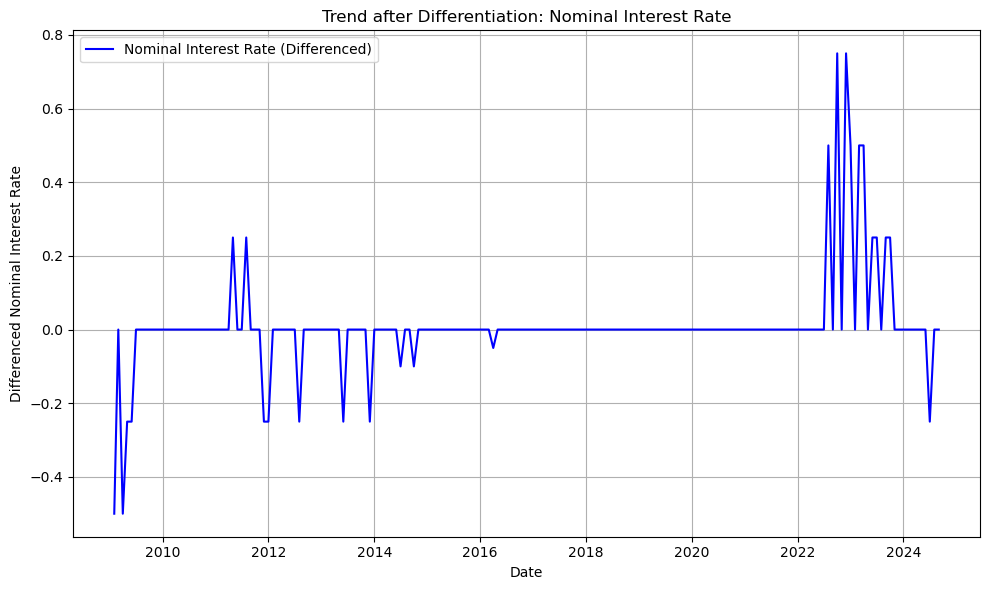

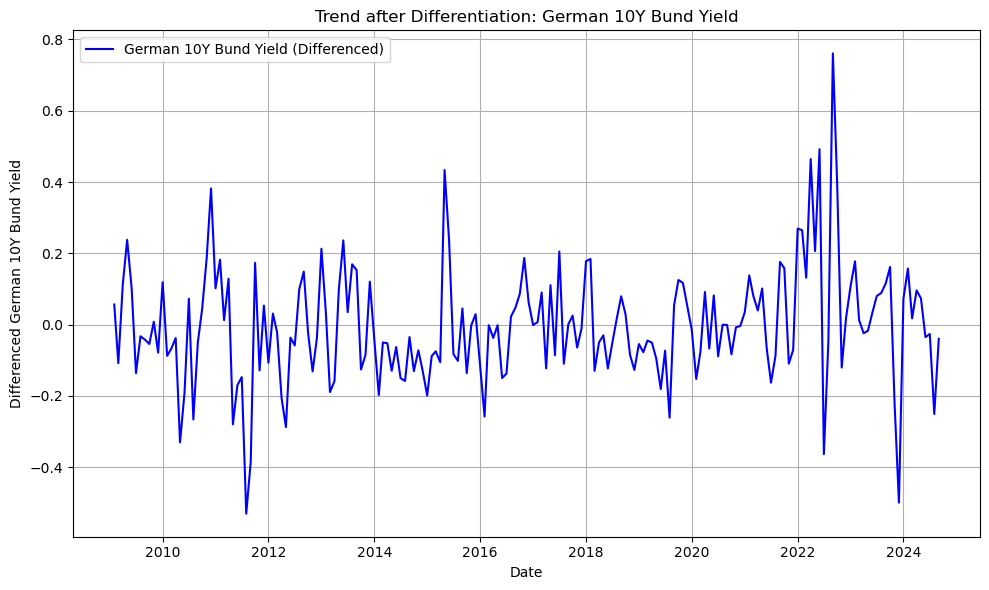

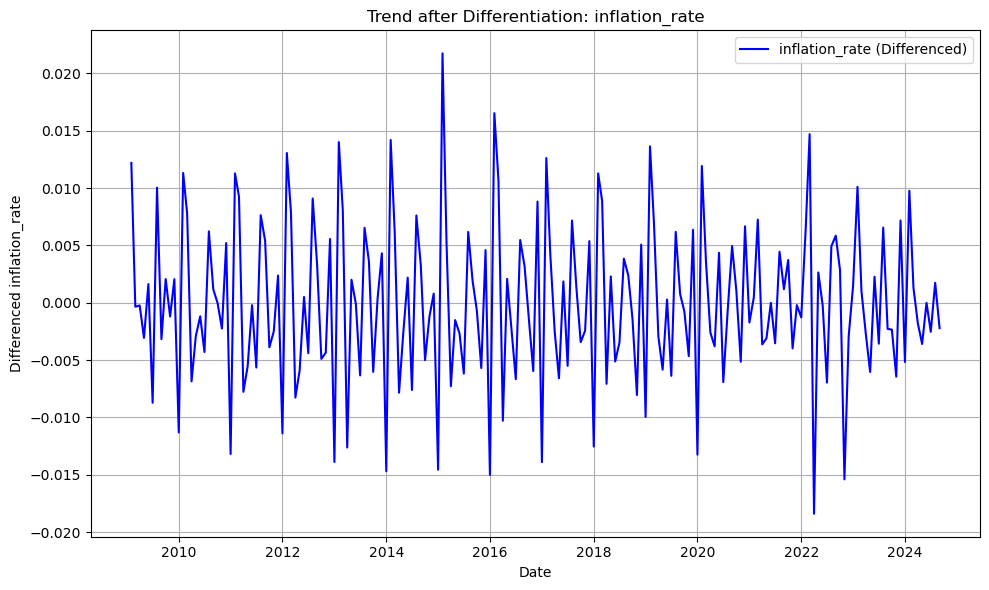

In [105]:
# Create a new DataFrame to hold the differentiated series where necessary
df_diff = pd.DataFrame()

# Differentiating the series that need to be differenced
df_diff['Nominal Interest Rate'] = df_combined['Nominal Interest Rate'].diff().dropna()
df_diff['German 10Y Bund Yield'] = df_combined['German 10Y Bund Yield'].diff().dropna()
df_diff['inflation_rate'] = df_combined['inflation_rate'].diff().dropna()

# Ensure that dates align correctly after differencing
df_diff = df_diff.dropna()

# Now, you can plot the differentiated DataFrame
def plot_diff_trend(df, name):
    plt.figure(figsize=(10, 6))
    plt.plot(df[name], label=f'{name} (Differenced)', color='blue')
    plt.title(f'Trend after Differentiation: {name}')
    plt.xlabel('Date')
    plt.ylabel(f'Differenced {name}')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot the differentiated series
plot_diff_trend(df_diff, 'Nominal Interest Rate')
plot_diff_trend(df_diff, 'German 10Y Bund Yield')
plot_diff_trend(df_diff, 'inflation_rate')



**VAR Modeling**

*VAR in levels to capture the short-term relationships between variables.//
Select the optimal number of lags that minimizes the value of the information criteria.*

*Lag selection - Information Criteria*

In [106]:
df_levels = df_combined[['Nominal Interest Rate', 'German 10Y Bund Yield', 'inflation_rate']]
df_levels = df_levels.dropna()

# Fitting a VAR model in levels
var_model = VAR(df_levels)

# Selecting the optimal number of lags using information criteria
lag_order_selection = var_model.select_order(maxlags=24)
print(f'Optimal Lag Order according to AIC: {lag_order_selection.aic}')
print(f'Optimal Lag Order according to BIC: {lag_order_selection.bic}')
print(f'Optimal Lag Order according to HQIC: {lag_order_selection.hqic}')

Optimal Lag Order according to AIC: 12
Optimal Lag Order according to BIC: 6
Optimal Lag Order according to HQIC: 12


In [107]:
# Fitting the VAR model in levels
model = VAR(df_combined)
lag_order = model.select_order(maxlags=24)
print(lag_order.summary())
 
# Fit the VAR model
var_model = model.fit(lag_order.aic)
print(var_model.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -10.43      -10.38   2.945e-05      -10.41
1       -18.16      -17.94   1.296e-08      -18.07
2       -18.25      -17.85   1.188e-08      -18.09
3       -18.39      -17.83   1.030e-08      -18.16
4       -18.59      -17.86   8.456e-09      -18.29
5       -18.66      -17.76   7.895e-09      -18.29
6       -19.05     -17.97*   5.359e-09      -18.61
7       -19.11      -17.86   5.059e-09      -18.60
8       -19.11      -17.69   5.077e-09      -18.53
9       -19.03      -17.45   5.471e-09      -18.39
10      -19.03      -17.27   5.536e-09      -18.31
11      -18.99      -17.07   5.751e-09      -18.21
12     -19.60*      -17.51  3.155e-09*     -18.75*
13      -19.59      -17.33   3.206e-09      -18.67
14      -19.54      -17.12   3.374e-09      -18.56
15      -19.53      -16.93   3.463e-09      -18.47
16      -19.54      -16.77   3.

*VAR in difference- think do not need*

In [49]:
# Fitting the VAR model in differences
model_diff = VAR(df_diff)
lag_order_diff = model_diff.select_order(maxlags=15)
print(lag_order_diff.summary())

# Fit the VAR model
var_model_diff = model_diff.fit(lag_order_diff.aic)
print(var_model_diff.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -17.57      -17.52   2.336e-08      -17.55
1       -17.81      -17.59   1.843e-08      -17.72
2       -18.08      -17.70   1.404e-08      -17.92
3       -18.29      -17.74   1.140e-08      -18.07
4       -18.46      -17.75   9.576e-09      -18.17
5       -18.98     -18.10*   5.710e-09      -18.62
6       -19.01      -17.96   5.575e-09      -18.58
7       -19.00      -17.79   5.628e-09      -18.51
8       -18.96      -17.58   5.891e-09      -18.40
9       -18.91      -17.37   6.155e-09      -18.29
10      -18.86      -17.15   6.507e-09      -18.17
11      -19.48      -17.60   3.535e-09     -18.72*
12     -19.53*      -17.49  3.362e-09*      -18.70
13      -19.51      -17.30   3.469e-09      -18.61
14      -19.50      -17.13   3.512e-09      -18.54
15      -19.47      -16.93   3.651e-09      -18.44
-------------------------------

**Test Johansen for Cointegration**

*Test Johansen on the VAR in levels to check if the variables are cointegrated.*

In [150]:
# Function to perform Johansen cointegration test
def johansen_test(df, det_order=-1, k_ar_diff=12, signif=0.05):
    result = coint_johansen(df, det_order, k_ar_diff)
    
    print(f'\n{"="*40}')
    print('Johansen Cointegration Test Results')
    print(f'{"="*40}\n')
    
    print('Eigenvalues:')
    print(f'{result.eig}\n')
    
    # Trace test
    print(f'Trace Test Statistics:')
    for i, trace_stat in enumerate(result.lr1):
        critical_value_5 = result.cvt[i, 1]
        print(f'   Trace Statistic (r ≤ {i}): {trace_stat:.4f}')
        print(f'   Critical Value (5%): {critical_value_5:.4f}')
        if trace_stat > critical_value_5:
            print(f'   Conclusion: Reject H0 (r ≤ {i}), there is at least {i+1} cointegration relation(s).')
        else:
            print(f'   Conclusion: Fail to reject H0 (r ≤ {i}), there are {i} cointegration relation(s).\n')
    
    # Maximum eigenvalue test
    print(f'Maximum Eigenvalue Test Statistics:')
    for i, max_eigen_stat in enumerate(result.lr2):
        critical_value_5 = result.cvm[i, 1]
        print(f'   Max-Eigen Statistic (r ≤ {i}): {max_eigen_stat:.4f}')
        print(f'   Critical Value (5%): {critical_value_5:.4f}')
        if max_eigen_stat > critical_value_5:
            print(f'   Conclusion: Reject H0 (r ≤ {i}), there is at least {i+1} cointegration relation(s).')
        else:
            print(f'   Conclusion: Fail to reject H0 (r ≤ {i}), there are {i} cointegration relation(s).\n')
    
    print(f'{"="*40}')
    
    # Summary of results
    trace_cointegrations = sum(result.lr1 > result.cvt[:, 1])
    max_eigen_cointegrations = sum(result.lr2 > result.cvm[:, 1])
    
    print(f'Summary:')
    print(f'   Number of cointegration relations according to Trace Test: {trace_cointegrations}')
    print(f'   Number of cointegration relations according to Max-Eigenvalue Test: {max_eigen_cointegrations}')
    
    if trace_cointegrations == max_eigen_cointegrations:
        print(f'   Final Conclusion: There are exactly {trace_cointegrations} cointegration relation(s) at {signif*100}% significance level.')
    else:
        print(f'   Final Conclusion: Trace and Max-Eigenvalue tests suggest different numbers of cointegration relations.')
    
    print(f'{"="*40}')

# Aplicar el Test de Johansen sin GDP Growth (usando 12 rezagos)
# Asumiendo que df_combined contiene las series en niveles
johansen_test(df_combined[['Nominal Interest Rate', 'German 10Y Bund Yield', 'inflation_rate']], k_ar_diff=12)


Johansen Cointegration Test Results

Eigenvalues:
[0.12016206 0.0485388  0.0005186 ]

Trace Test Statistics:
   Trace Statistic (r ≤ 0): 31.3795
   Critical Value (5%): 24.2761
   Conclusion: Reject H0 (r ≤ 0), there is at least 1 cointegration relation(s).
   Trace Statistic (r ≤ 1): 8.8484
   Critical Value (5%): 12.3212
   Conclusion: Fail to reject H0 (r ≤ 1), there are 1 cointegration relation(s).

   Trace Statistic (r ≤ 2): 0.0913
   Critical Value (5%): 4.1296
   Conclusion: Fail to reject H0 (r ≤ 2), there are 2 cointegration relation(s).

Maximum Eigenvalue Test Statistics:
   Max-Eigen Statistic (r ≤ 0): 22.5311
   Critical Value (5%): 17.7961
   Conclusion: Reject H0 (r ≤ 0), there is at least 1 cointegration relation(s).
   Max-Eigen Statistic (r ≤ 1): 8.7571
   Critical Value (5%): 11.2246
   Conclusion: Fail to reject H0 (r ≤ 1), there are 1 cointegration relation(s).

   Max-Eigen Statistic (r ≤ 2): 0.0913
   Critical Value (5%): 4.1296
   Conclusion: Fail to reject H0

In [109]:
# Perform Johansen's cointegration test
johansen_test = coint_johansen(df_combined, det_order=0, k_ar_diff=1)

# Display test statistics
print(johansen_test.lr1)   # Trace statistics
print(johansen_test.cvt)   # Critical values

[101.80535886   4.37324223   0.53707824]
[[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


**VECM rank = 1**

*long-term relationship*

In [110]:
# Step 1: Select the optimal lag order
def select_vecm_lag_order(df, maxlags=24):
    """
    Select the optimal lag order for VECM using information criteria.
    """
    lag_selection = select_order(df, maxlags=maxlags, deterministic="ci")
    print(f'\nOptimal lag order:')
    print(f'AIC: {lag_selection.aic}')
    print(f'BIC: {lag_selection.bic}')
    print(f'HQIC: {lag_selection.hqic}')
    return lag_selection

# Step 2: Determine the number of cointegration relationships
def select_cointegration_rank(df, det_order=-1, maxlags=12, signif=0.05):
    """
    Select the number of cointegration relations (r) using the Johansen test.
    """
    result = select_coint_rank(df, det_order=det_order, k_ar_diff=maxlags, method="trace", signif=signif)
    print(f'\nNumber of cointegration relationships (r): {result.rank}')
    return result.rank

# Step 3: Fit the VECM model
def fit_vecm(df, coint_rank, lags):
    """
    Fit a VECM model with the selected number of cointegration relationships and lags.
    """
    model = VECM(df, k_ar_diff=lags, coint_rank=coint_rank, deterministic="ci")
    vecm_fitted = model.fit()
    
    print(f'\n{"="*40}')
    print('Fitted VECM Model Summary')
    print(f'{"="*40}\n')
    print(vecm_fitted.summary())
    
    return vecm_fitted

# Step 4: Implement the analysis with your data
# Select the optimal lag order
lag_selection = select_vecm_lag_order(df_combined[['Nominal Interest Rate', 'German 10Y Bund Yield', 'inflation_rate']], maxlags=12)

# Select the number of cointegration relationships (r)
coint_rank = select_cointegration_rank(df_combined[['Nominal Interest Rate', 'German 10Y Bund Yield', 'inflation_rate']], maxlags=12)

# Fit the VECM model
vecm_fitted = fit_vecm(df_combined[['Nominal Interest Rate', 'German 10Y Bund Yield', 'inflation_rate']], coint_rank=coint_rank, lags=lag_selection.aic)


Optimal lag order:
AIC: 11
BIC: 5
HQIC: 11

Number of cointegration relationships (r): 1

Fitted VECM Model Summary

Det. terms outside the coint. relation & lagged endog. parameters for equation Nominal Interest Rate
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
L1.Nominal Interest Rate     -0.1166      0.075     -1.565      0.118      -0.263       0.029
L1.German 10Y Bund Yield     -0.0081      0.041     -0.196      0.844      -0.089       0.073
L1.inflation_rate           -19.3299      4.776     -4.047      0.000     -28.692      -9.968
L2.Nominal Interest Rate      0.3303      0.074      4.462      0.000       0.185       0.475
L2.German 10Y Bund Yield      0.0810      0.043      1.898      0.058      -0.003       0.165
L2.inflation_rate           -16.4918      4.652     -3.545      0.000     -25.610      -7.374
L3.Nominal Interest Rate     

**Granger causality test**

*From VECM, determine whether past values of one variable help to predict future values of another variable, accounting for both short-term dynamics and long-term cointegration*

In [149]:
# Granger causality test function
def granger_causality_test(vecm_fitted, variables):
    print("\nGranger Causality Test Results:\n")
    for caused in range(len(variables)):
        for causing in range(len(variables)):
            if caused != causing:
                # Perform the test for each pair of variables
                test_result = vecm_fitted.test_granger_causality(caused=caused, causing=causing)
                print(f"Testing if {variables[causing]} Granger-causes {variables[caused]}:")
                print(test_result.summary())
                print("\n" + "="*40 + "\n")

# List of variable names in the dataset (order matters)
variables = ['Nominal Interest Rate', 'German 10Y Bund Yield', 'Inflation Rate']

# Run the Granger causality tests on the VECM model
granger_causality_test(vecm_fitted, variables)


Granger Causality Test Results:

Testing if German 10Y Bund Yield Granger-causes Nominal Interest Rate:
Granger causality F-test. H_0: German 10Y Bund Yield does not Granger-cause Nominal Interest Rate. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         3.718          1.776   0.000 (12, 408)
-----------------------------------------------


Testing if Inflation Rate Granger-causes Nominal Interest Rate:
Granger causality F-test. H_0: inflation_rate does not Granger-cause Nominal Interest Rate. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         3.299          1.776   0.000 (12, 408)
-----------------------------------------------


Testing if Nominal Interest Rate Granger-causes German 10Y Bund Yield:
Granger causality F-test. H_0: Nominal Interest Rate does not Granger-cause German 

**IRF-Impulse Reaction Function**

*IRF VAR in levels*

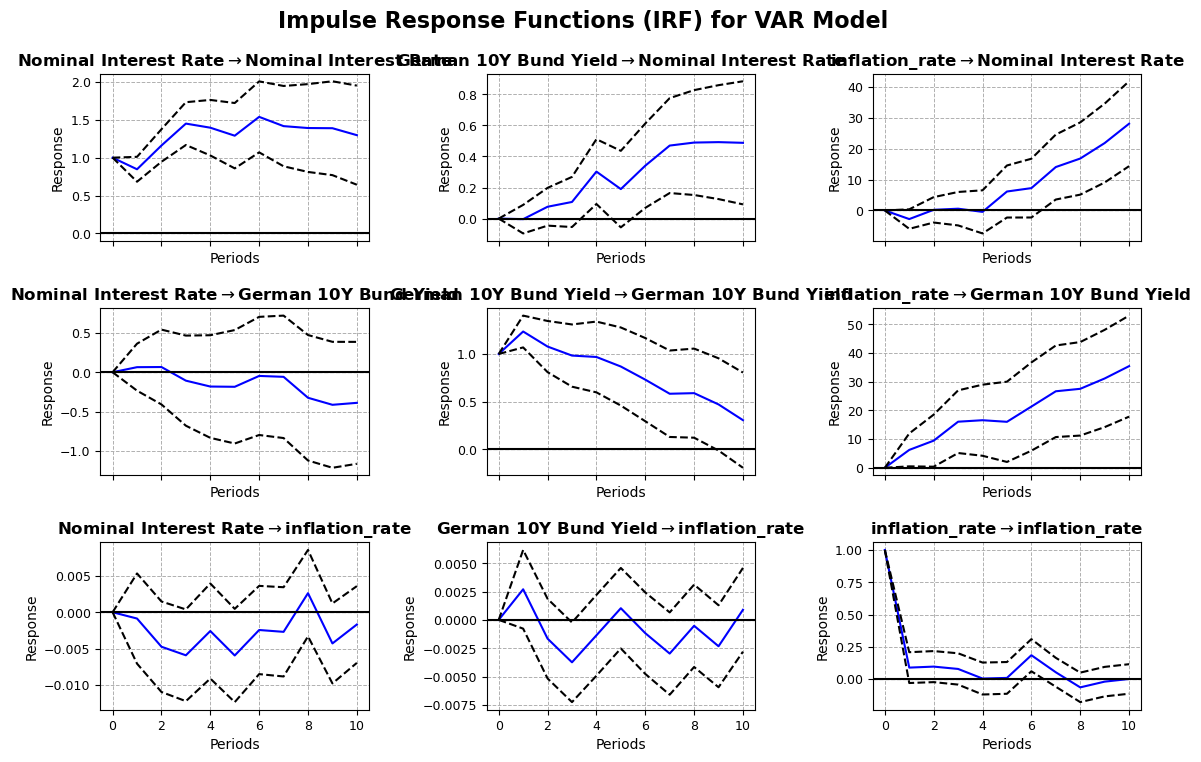

In [148]:
# Function to plot IRF with improved aesthetics and spacing
def plot_irf_enhanced(irf, periods=10, orth=False):
    fig = irf.plot(orth=orth, figsize=(12, 8))

    # Customize each subplot for better aesthetics
    for ax in fig.axes:
        ax.set_title(ax.get_title(), fontsize=12, fontweight='bold')
        ax.set_xlabel('Periods', fontsize=10)
        ax.set_ylabel('Response', fontsize=10)
        ax.grid(True, which='both', linestyle='--', linewidth=0.7)
        ax.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add a horizontal line at y=0

        # Adjust tick parameters for readability
        ax.tick_params(axis='both', which='major', labelsize=9)

    # Add a main title and adjust layout
    fig.suptitle('Impulse Response Functions (IRF) for VAR Model', fontsize=16, fontweight='bold')

    # Adjust subplot spacing
    fig.tight_layout(pad=3.0)  # Adjust the padding between subplots
    fig.subplots_adjust(top=0.9, hspace=0.4)  # Adjust top space and height spacing

    plt.show()

# with VAR model
irf = var_model.irf(10)  # 10 periods ahead
plot_irf_enhanced(irf, periods=10, orth=False)

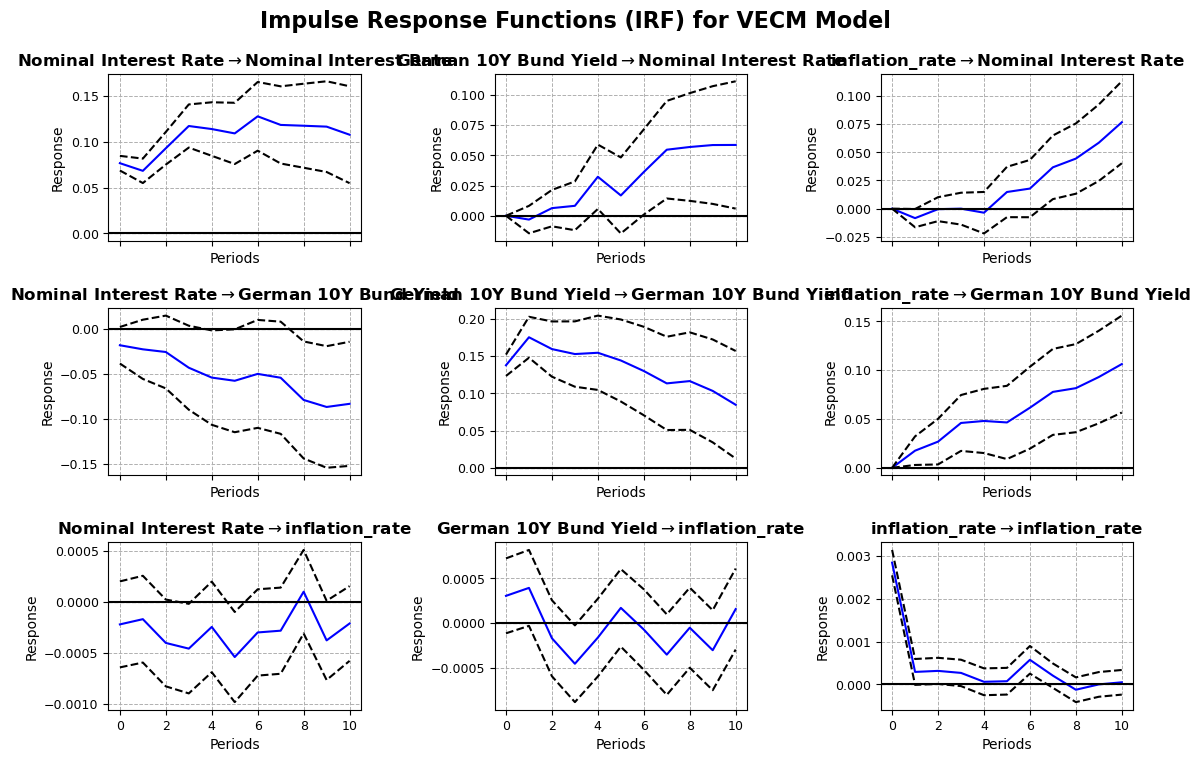

In [144]:
# Function to generate and plot impulse response functions with improved aesthetics
def impulse_response_analysis_enhanced(vecm_fitted, steps=10):
    irf = vecm_fitted.irf(periods=steps)
    
    # Plot the impulse response functions with enhanced formatting
    fig = irf.plot(orth=True, figsize=(12, 8))
    
    # Customize each subplot for better aesthetics
    for ax in fig.axes:
        ax.set_title(ax.get_title(), fontsize=12, fontweight='bold')
        ax.set_xlabel('Periods', fontsize=10)
        ax.set_ylabel('Response', fontsize=10)
        ax.grid(True, which='both', linestyle='--', linewidth=0.7)
        ax.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add a horizontal line at y=0
        
        # Adjust tick parameters for readability
        ax.tick_params(axis='both', which='major', labelsize=9)

    # Add a main title and adjust layout
    fig.suptitle('Impulse Response Functions (IRF) for VECM Model', fontsize=16, fontweight='bold')

    # Adjust subplot spacing
    fig.tight_layout(pad=3.0)  # Increase padding between subplots for clarity
    fig.subplots_adjust(top=0.9, hspace=0.4)  # Adjust top margin and vertical space

    plt.show()

# Perform impulse response analysis for the next 10 periods
impulse_response_analysis_enhanced(vecm_fitted, steps=10)


**White noise test -ljung_box_test**

In [145]:
# Function to perform Ljung-Box test on VECM residuals
def ljung_box_test(vecm_fitted, lags=10):
    residuals = pd.DataFrame(vecm_fitted.resid, columns=vecm_fitted.names)
    
    print("\nLjung-Box Test Results:\n")
    for col in residuals.columns:
        lb_test = acorr_ljungbox(residuals[col], lags=lags, return_df=True)
        print(f"Variable: {col}")
        print(lb_test)
        print("\n" + "="*40 + "\n")

# Perform Ljung-Box test on the residuals of the fitted VECM model
ljung_box_test(vecm_fitted, lags=10)



Ljung-Box Test Results:

Variable: Nominal Interest Rate
     lb_stat  lb_pvalue
1   0.046179   0.829851
2   0.046257   0.977137
3   0.153230   0.984761
4   0.312776   0.988975
5   0.313221   0.997387
6   0.366710   0.999104
7   0.483374   0.999505
8   0.516008   0.999850
9   0.953860   0.999537
10  1.663682   0.998329


Variable: German 10Y Bund Yield
     lb_stat  lb_pvalue
1   0.017559   0.894581
2   0.020462   0.989821
3   0.020541   0.999222
4   0.029243   0.999894
5   0.136486   0.999651
6   0.136487   0.999950
7   0.269211   0.999931
8   0.480130   0.999886
9   1.143092   0.999031
10  1.148215   0.999677


Variable: inflation_rate
      lb_stat  lb_pvalue
1    2.875567   0.089933
2    3.349714   0.187335
3    3.952568   0.266632
4    5.140813   0.273152
5    5.145589   0.398372
6    5.852742   0.439887
7   13.061464   0.070625
8   13.419697   0.098202
9   13.581683   0.138003
10  14.802454   0.139432




**Forecasting with fitted VECM**

In [146]:
# function to forecast using VECM
def forecast_vecm(vecm_fitted, steps=10):
    forecast_values = vecm_fitted.predict(steps=steps)
    
    # Create a DataFrame for the forecasted values
    forecast_df = pd.DataFrame(forecast_values, columns=vecm_fitted.names)
    return forecast_df

# Forecast the next 10 periods
forecast_df = forecast_vecm(vecm_fitted, steps=10)

# Display the forecasted values
print("\nForecasted values for the next 10 periods:")
print(forecast_df)


Forecasted values for the next 10 periods:
   Nominal Interest Rate  German 10Y Bund Yield  inflation_rate
0               4.191376               2.152622        0.001649
1               4.161698               2.040424       -0.003003
2               4.159112               1.936784        0.001385
3               4.081325               1.906794       -0.002646
4               3.990549               1.876285        0.005767
5               3.915416               1.965790        0.005258
6               3.844599               1.961795        0.004863
7               3.781088               1.918193        0.003108
8               3.690130               1.907839        0.002273
9               3.655208               1.839670        0.000848


Index(['Nominal Interest Rate', 'German 10Y Bund Yield', 'inflation_rate'], dtype='object')


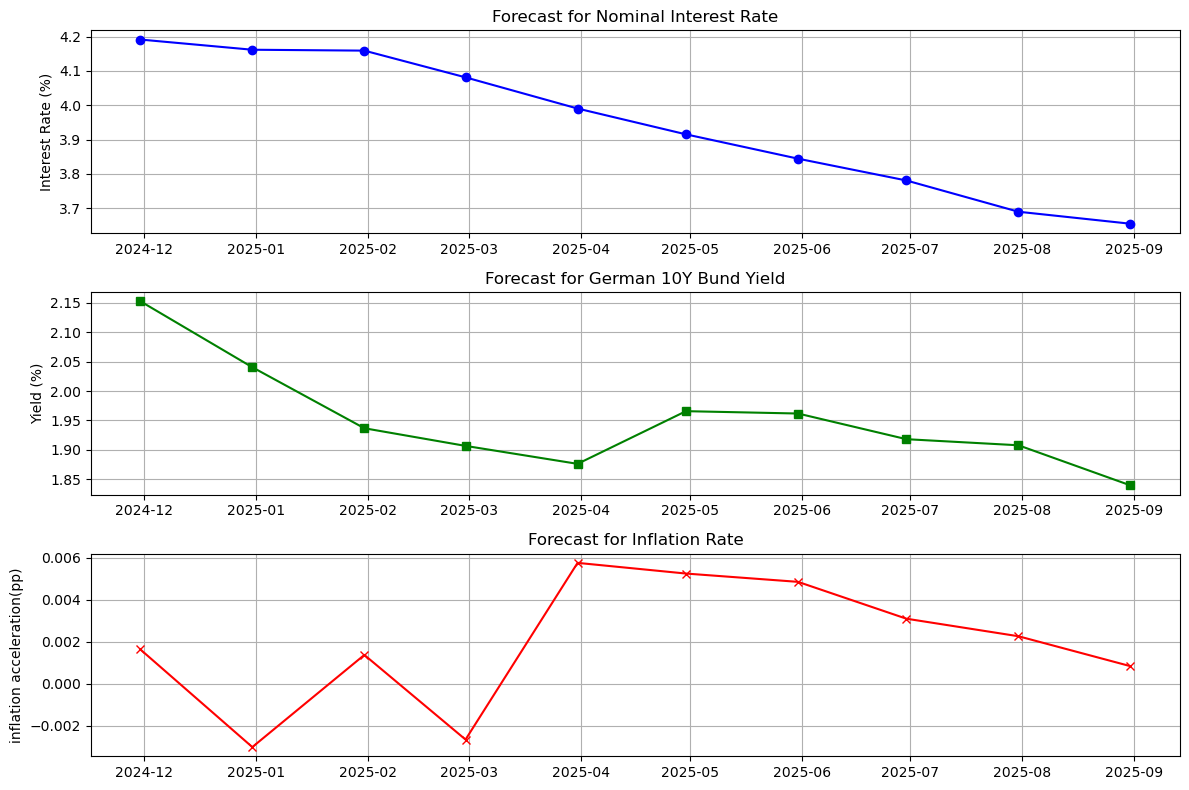

In [147]:
def plot_forecast(forecast_df):
    plt.figure(figsize=(12, 8))

    # Plot for Nominal Interest Rate
    plt.subplot(3, 1, 1)
    plt.plot(forecast_df.index, forecast_df["Nominal Interest Rate"], marker='o', label="Nominal Interest Rate", color='b')
    plt.title('Forecast for Nominal Interest Rate')
    plt.ylabel('Interest Rate (%)')
    plt.grid(True)

    # Plot for German 10Y Bund Yield
    plt.subplot(3, 1, 2)
    plt.plot(forecast_df.index, forecast_df["German 10Y Bund Yield"], marker='s', label="German 10Y Bund Yield", color='g')
    plt.title('Forecast for German 10Y Bund Yield')
    plt.ylabel('Yield (%)')
    plt.grid(True)

    # Plot for Inflation Rate
    plt.subplot(3, 1, 3)
    plt.plot(forecast_df.index, forecast_df["inflation_rate"], marker='x', label="Inflation Rate", color='r')
    plt.title('Forecast for Inflation Rate')
    plt.ylabel('inflation acceleration(pp)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Display the correct column names
print(forecast_df.columns)

# Adjust the index of the forecast DataFrame for the plot
forecast_df.index = pd.date_range(start="2024-11-01", periods=10, freq="M")

# Call the plot function to visualize the forecasted data
plot_forecast(forecast_df)